# Molecular dynamics simulation of argon atoms

This notebook contains python code to simulate the molecular dynamics of a collection of argon atoms. From the microscopic simulation results, a few macroscopic quantities will be calculated

Let's start by importing everything we need

In [2]:
%matplotlib inline

import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import sys
from IPython import display

def print_fl(output):
    print(output)
    sys.stdout.flush()

## System parameters 

In the following block, all relevant system parameters are set.

In [13]:
## simulation parameters
simulationTime = 40.0 # total simulation time
h = 0.004 # time step
numSteps = int(simulationTime/h) # number of simulation steps
numFrames = 50 # number of frames of the molecular configuration to be shown during simulation
reportFreq = 0.01 # fraction of simulation progress that should be reported by a short text message

rescalingPeriod = 100 # number of time steps between each velocity rescaling to reach the desired temperature
rescalingTime = 15.0 # time until we should do the rescaling procedure to end up at the desired temperature
equilibrationTime = 20.0 # time until we consider the system to be in equilibrium
equilibriumStart = int(equilibrationTime/h) # time step from which we consider the system to be in equilibrium

## system parameters
M = 4 # number of unit cells to initialize atoms in

desiredT = 3.0 # temperature the system should be equilibrated towards
rho = 0.1 # density of the system

n = 4*M**3 # total number of atoms to be simulated
sigma_v = np.sqrt(desiredT) # spread of the initial velocities
L = np.power(n/rho, 1/3) # linear size of the (cubic) system

## output data
t = 0 # initialize simulation time to zero
v = np.zeros((numSteps,n,3)) # matrix to hold the 3 velocity components per atom at every time step
r = np.zeros((numSteps,n,3)) # matrix to hold the 3 spatial coordinates per atom at every time step
rNoPBC = np.zeros((numSteps,n,3)) # matrix to hold the 3 spatial coordinates per atom to which the PBC have *not* been applied (for diffusion)
v_hat = np.zeros((numSteps,n,3)) # matrix to hold intermediate velocities during simulation (specific to the Verlet algorithm)

dist = np.zeros((numSteps,n,n)) # matrix to hold the distances between all atoms at every time step
F = np.zeros((numSteps,n,3)) # matrix to hold the forces between all atoms at every time step

# keep track of a distance histogram to calculate the correlation function from
distHistBins = 200
distHistBinSize = np.sqrt(3)*L/(2*distHistBins)
distHist = np.zeros((numSteps, distHistBins+1))

# matrices to hold potential and kinetic energies at every time step
U = np.zeros((numSteps))
K = np.zeros((numSteps))
# matrix to hold the value of the virial coefficient at every time step
virial = np.zeros((numSteps))

visualize = True

## Initialisation functions

This is where we define the initial configuration of the sytem. The initialise function puts all the atoms in an fcc Bravais lattice, the minimum potential energy configuration for the Lennard-Jones potential (provided the unit cell spacing coincides with the minimum in the LJ pair potential). Velocity components are distributed randomly according to a Gaussian distribution.

The initialise_simple function puts only two atoms in the system which is very useful for debugging purposes.

In [14]:
def initialise(set_v = True):
    global simulationTime, h, numSteps, t, M, n, v, r, rNoPBC, v_hat, m, beta, sigma_v, F, L, dist, rho
    t = 0
    i = 0
    for mx in range(0, M):
        for my in range(0, M):
            for mz in range(0, M):
                r[t,i,0] = L*mx/M; r[t,i,1] = L*my/M; r[t,i,2] = L*mz/M
                i += 1
                r[t,i,0] = L*(mx+0.5)/M; r[t,i,1] = L*(my+0.5)/M; r[t,i,2] = L*mz/M
                i += 1
                r[t,i,0] = L*(mx+0.5)/M; r[t,i,1] = L*my/M; r[t,i,2] = L*(mz+0.5)/M
                i += 1
                r[t,i,0] = L*mx/M; r[t,i,1] = L*(my+0.5)/M; r[t,i,2] = L*(mz+0.5)/M
                i += 1
    rNoPBC[t,:,:] = r[t,:,:]
    
    if set_v:
        v[t,:,:] = np.random.normal(0.0, sigma_v, size=(n,3))
        v[t,:,:] = (v[t,:,:] - np.mean(v[t,:,:], axis=0)) / np.std(v[t,:,:]) * sigma_v
    else:
        v[t,:,:] = 0.0
    K[t] = 0.5*np.sum(v[t,:,:]*v[t,:,:])


def initialise_simple():
    global simulationTime, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho
    
    M = 3
    n = 2
    
    v = np.zeros((numSteps,n,3))
    r = np.zeros((numSteps,n,3))
    v_hat = np.zeros((numSteps,n,3))
    
    L = 3

    dist = np.zeros((numSteps,n,n))
    F = np.zeros((numSteps,n,3))
    
    v[t,:,:] = 0.0
    r[t,0,:] = [L-0.55*np.power(2.0,1.0/6.0), L/2, L/2]
    r[t,1,:] = [0.55*np.power(2.0,1.0/6.0), L/2, L/2]



## Simulation algorithm

In the functions below is where the real work happens. The update_coordinates function updates the positions and the velocities of the atoms using the Verlet algorithm. Forces (and other useful quantities) are calculated using the calculate_quantities_jit function, which is fed into the numba JIT compiler for maximum efficiency. In this function, array calculations are actually unwound and written explicitly as it turns out that this was faster after JIT compilation than numpy array operations. This jitted function is wrapped inside a normal function in order to access the global variables we use to save our experimental results

In [15]:
def update_coordinates():
    global simulationTime, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho
    global distHist, distHistBins, distHistBinSize
    v_hat[t,:,:] = v[t,:,:] + h * F[t,:,:]/2
    r[t + 1,:,:] = (r[t,:,:] + h * v_hat[t,:,:]) % L
    rNoPBC[t + 1,:,:] = (rNoPBC[t,:,:] + h * v_hat[t,:,:])
    
    # calculate all the relevant quantities for the simulation
    t += 1
    calculate_quantities()
    
    v[t,:,:] = v_hat[t-1,:,:] + h*F[t,:,:] / 2
    K[t] = 0.5*np.sum(v[t,:,:]*v[t,:,:])

# note that global variables in jitted functions are frozen at compile-time,
# so it is better to pass in all the system parameters every time
@jit(nopython=True)
def calculate_quantities_jit(rIn, LIn, distHistBinsIn, distHistBinSizeIn):
    # apply periodic boundary conditions here
    nIn = rIn.shape[0]
    distOut = np.zeros((nIn, nIn))
    FOut = np.zeros((nIn, 3))
    distHistOut = np.zeros((distHistBinsIn+1))
    UOut = 0.0
    virialOut = 0.0
    epsilon = 1e-5 # fail safe in case distances between atoms become zero
    # loop through all of the atom pairs once
    for i in range(0,nIn):
        for j in range(0,i):
            # calculate distance
            dx = rIn[i,0] - rIn[j,0]
            dx -= np.around(dx/LIn) * LIn
            
            dy = rIn[i,1] - rIn[j,1]
            dy -= np.around(dy/LIn) * LIn
            
            dz = rIn[i,2] - rIn[j,2]
            dz -= np.around(dz/LIn) * LIn
            
            dr = np.sqrt(dx*dx + dy*dy + dz*dz)
            if dr == 0.0:
                # use failsafe small value for r in case the distance is zero
                # to prevent division by zero in the force calculation
                # note that the simulation will fail anyway probably as this
                # will introduce a huge potential energy but just in case
                dr = epsilon
            distOut[i,j] = distOut[j,i] = dr
            
            # put distance in distance histogram
            distHistOut[int(dr/distHistBinSizeIn)] += 1
            
            # calculate potential, force and virial, using the following intermediate result
            # for computational efficiency (2x speed-up)
            dr_6 = dr**6            
            UOut += 4.0*(1/(dr_6*dr_6) - 1/dr_6) 
            
            fLJ = (48.0/(dr_6*dr_6*dr) - 24.0/(dr_6*dr))
            virialOut += dr*fLJ
            
            f_x = dx / dr * fLJ
            f_y = dy / dr * fLJ
            f_z = dz / dr * fLJ
            
            FOut[i,0] += f_x
            FOut[i,1] += f_y
            FOut[i,2] += f_z
            
            FOut[j,0] += -f_x
            FOut[j,1] += -f_y
            FOut[j,2] += -f_z
    # return all the wonderfull things we've calculated
    return distOut, FOut, distHistOut, UOut, virialOut

def calculate_quantities():
    # we can't use globals inside a jitted function, so we provide this little wrapper function
    global simulationTime, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho
    global distHist, distHistBins, distHistBinSize
    dist[t,:,:], F[t,:,:], distHist[t,:], U[t], virial[t] = calculate_quantities_jit(r[t,:,:], L, distHistBins, distHistBinSize)

## Temperature rescaling

In order to attain the desired temperature, the kinetic energy (which is related to the temperature) may be rescaled using the following function. This function is called a few times inside the simulation loop during equilibration

In [16]:
def scale_to_temperature():
    global n, v, desiredT, rescalingPeriod
    # average the velocities over the second half of the last rescaling period
    halfRP = int(rescalingPeriod/2)
    lbda = np.sqrt((n - 1)*3*desiredT*halfRP/(2*np.sum(K[t-halfRP:t])))
    
    v[t,:,:] *= lbda

## Simulation loop

All the pieces are tied together in the following simulation loop. Functions for visualizing the intermediate results are also provided.

In [17]:
def do_simulation():
    global simulationTime, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho  
    global rescalingPeriod, equilibrationTime
    global numFrames
    start_visualisation()
    
    np.random.seed()
    t = 0
    initialise()
    calculate_quantities()
    while(t < numSteps - 1):
        if (t*h < rescalingTime and t > 0 and t % rescalingPeriod == 0):
            scale_to_temperature()
        if (t % int(numSteps*reportFreq) == 0):
            print_fl("Simulation progress: " + str(int(t*100/numSteps)) + "%")
        if (t % int(numSteps/numFrames) == 0):
            visualize()   
        update_coordinates()
    end_visualisation()
    print_fl("Simulation finished")

fig = None
ax = None

def start_visualisation():
    global simulationTime, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho
    global fig, ax
    global visualize
    if not visualize:
        return
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
def end_visualisation():
    global visualize
    if not visualize:
        return
    display.clear_output()

def visualize():
    global simulationTime, h, numSteps, t, M, n, v, r, v_hat, m, beta, sigma_v, F, L, dist, rho
    global fig, ax
    global visualize
    if not visualize:
        return
    ax.cla()
    ax.scatter(r[t,:,0], r[t,:,1], r[t,:,2])
    ax.set_xlim((0.0, L))
    ax.set_ylim((0.0, L))
    ax.set_zlim((0.0, L))
    display.clear_output(wait=True)
    display.display(fig)
    #time.sleep(0.05)

## Speed test

In order to investigate the feasibility of the simulation, the main component of the simulation loop (calculating the forces and other quantities and executing the Verlet algorithm) is timed in the following section. 

In [18]:
initialise()

def test_update_coordinates():
    global t
    t = 0
    update_coordinates()
    t = 0
calculate_quantities()
test_update_coordinates()

%timeit test_update_coordinates()

1000 loops, best of 3: 1.85 ms per loop


## Running the simulation

Now we've provided all the machinery, it is time to run the simulation!

Simulation finished


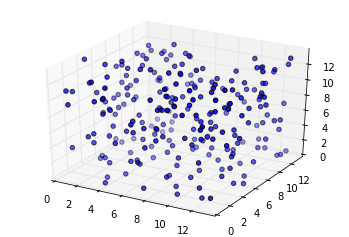

In [19]:
do_simulation()

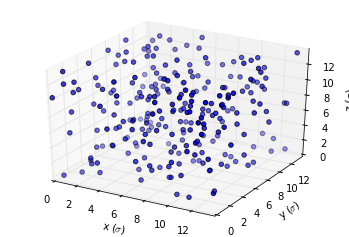

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r[t,:,0], r[t,:,1], r[t,:,2])
ax.set_xlim((0.0, L))
ax.set_ylim((0.0, L))
ax.set_zlim((0.0, L))
ax.set_xlabel(r"x ($\sigma$)")
ax.set_ylabel(r"y ($\sigma$)")
ax.set_zlabel(r"z ($\sigma$)")
plt.savefig("analysis/3d-atom-plot.png", dpi=300)

## Simulation results

After simulating, we may calculate and plot a few interesting physical quantities. The results are presented in the following section.

### Energies

Below we plot the development of the potential and kinetic energy, as well as their sum, during the simulation. Note that in the equilibration phase conservation of energy is violated by the temperature rescalings. After the rescalings stop we do observe that the total energy remains constant.

Initial K: 1151.96202669
Initial U: -36.4177044752
Initial H: 1115.54432222

Average K: 1155.15890042
Average U: -152.146898892
Average H: 1003.01200153
Average T: 3.00822630319


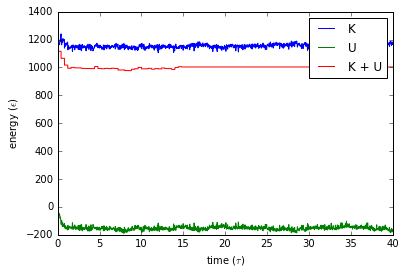

In [28]:
H = K + U
T = 2*K/(3*n)

print("Initial K: " + str(K[0]))
print("Initial U: " + str(U[0]))
print("Initial H: " + str(H[0]))
print("")
print("Average K: " + str(np.mean(K[equilibriumStart:])))
print("Average U: " + str(np.mean(U[equilibriumStart:])))
print("Average H: " + str(np.mean(H[equilibriumStart:])))

avgT = np.mean(T[equilibriumStart:])

print("Average T: " + str(avgT))

plt.plot(np.arange(0,numSteps) * h, K, label = "K")
plt.plot(np.arange(0,numSteps) * h, U, label = "U")
plt.plot(np.arange(0,numSteps) * h, H, label = "K + U")
plt.xlabel(r"time ($\tau$)")
plt.ylabel(r"energy ($\epsilon$)")
plt.legend()
plt.savefig("analysis/energy.png", dpi=300)

### Energy conservation

To investigate the conservation of energy in more detail, we plot the deviations in H. We see that after the equilbration phase the energy remains conserved indeed, up to some numerical errors.

In [ ]:
plt.plot(H - np.mean(H))

### Correlation function

From the distance histogram that has been saved during simulation, we may calculate the correlation function. The results are shown in the section below

In [ ]:
# determine the correlation function from the distance histogram
r_g = np.linspace(0.5*distHistBinSize, (distHistBins-0.5)*distHistBinSize, distHistBins)
g = np.mean(distHist[equilibriumStart:,:], axis=0)/(4*np.pi*distHistBinSize*r_g**2)*2*L**3/(n*(n-1))

plt.plot(r_g, g)

### Specific heat

Using Lebowitz' formula, we may calculate the specific heat from the fluctuations in the kinetic energy. This is performed in the following block of code

In [ ]:
delta_K_sq = np.var(K[equilibriumStart:])
K_sq = np.mean(K[equilibriumStart:])**2

C_v = 3 * K_sq / (2*K_sq - 3*n*delta_K_sq)

print("Specific heat: " + str(C_v))

### Pressure

The pressure can be calculated from the virial theorem. The result is determined below.

In [ ]:
P = 1 + 1/(3*n*avgT) * np.mean(virial[equilibriumStart:])

print("Pressure: " + str(P))

### Diffusion

Another interesting physical phenomenon we can observe in this molecular dynamics simulation, is the diffusion of argon atoms through the volume. To study this, the variance in the displacement of all the particles is plotted in the following section.

In [ ]:
deltaX = rNoPBC[equilibriumStart:,:,:] - rNoPBC[equilibriumStart,:,:]

diffDist = np.mean(np.sum(deltaX**2, axis=2), axis=1)

plt.plot(diffDist)